In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.special import gamma
from typing import Tuple
from scipy.special import gamma as gamma_func  # Gamma function

In [2]:
# Load the CSV file
df = pd.read_csv("../data/cleanv3_transform.csv")

In [3]:
# Filter out rows where 'INCZERO_ONE' or 'INCZERO_TWO' are equal to 1
df_filtered = df[(df['INCZERO_ONE'] != 1) & (df['INCZERO_TWO'] != 1)]

# Build the main dataframe with continuous target and predictors.
# NOTE: A factor has been added to center the peak of the target distribution at 0.
#       This factor must be removed at the end to obtain the final predictions.
df_data = pd.DataFrame({
    "target": df_filtered["INCLOG_DELTA"],
    "INCTOT": df_filtered["INCTOT"],
    "EDUC": df_filtered["EDUC"],
    "INCPER": df_filtered["INCPER"],
    "AGE": df_filtered["AGE"],
    "UHRSWORKLY": df_filtered["UHRSWORKLY"],
    "INCWAGE": df_filtered["INCWAGE"],
    "FTOTVAL": df_filtered["FTOTVAL"]
})

# Append additional continuous features (columns starting with "occ_" or "ind_")
df_data = pd.concat([df_data, df_filtered.filter(regex="^(occ_|ind_)")], axis=1)

# One-hot encode categorical features and add them as predictors.
categorical_features = ["LABFORCE", "EMPSTAT", "SEX"]
df_cat = pd.get_dummies(df_filtered[categorical_features], drop_first=False)
df_data = pd.concat([df_data, df_cat], axis=1)

In [6]:
# --------------------------
# Dataset
# --------------------------
class MyDataset(Dataset):
    def __init__(self, dataframe):
        # All columns except "target" are features.
        self.X = dataframe.drop(columns=["target"]).values.astype(np.float32)
        self.y = dataframe["target"].values.astype(np.float32)  # shape (N,)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --------------------------
# Model Definition
# --------------------------
class HierarchicalMDN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout_rate=0.2):
        """
        Constructs the hierarchical MDN model with dropout.
        Parameters:
           input_dim     : Dimension of input features.
           hidden_dim    : Size of hidden layers.
           dropout_rate  : Dropout rate for regularization.
        """
        super().__init__()
        
        # Shared feature extractor with dropout.
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate)
        )
        
        # Regime gating head: outputs a scalar, then sigmoid for ρ(x)
        self.regime_head = nn.Linear(hidden_dim, 1)
        
        # Positive-regime MDN head: outputs 6 values: 
        # 2 mixture logits, 2 shape (alpha) parameters, 2 scale (f) parameters.
        self.pos_head = nn.Linear(hidden_dim, 6)
        
        # Negative-regime MDN head: same structure as positive branch.
        self.neg_head = nn.Linear(hidden_dim, 6)
    
    def forward(self, x):
        h = self.shared(x)
        # Regime gating: probability for positive regime.
        regime_logit = self.regime_head(h)
        rho = torch.sigmoid(regime_logit)  # p(r = 1|x)
        
        # Positive branch:
        pos_out = self.pos_head(h)  # shape: (batch, 6)
        pos_mix_logits = pos_out[:, :2]  # first 2 entries for mixture weights
        pos_pi = F.softmax(pos_mix_logits, dim=1)  # ensure they sum to 1
        pos_alpha = F.softplus(pos_out[:, 2:4]) + 1e-3  # shape parameters (α); ensure > 0
        pos_scale = F.softplus(pos_out[:, 4:6]) + 1e-3    # scale parameters; ensure > 0
        
        # Negative branch:
        neg_out = self.neg_head(h)
        neg_mix_logits = neg_out[:, :2]
        neg_pi = F.softmax(neg_mix_logits, dim=1)
        neg_alpha = F.softplus(neg_out[:, 2:4]) + 1e-3
        neg_scale = F.softplus(neg_out[:, 4:6]) + 1e-3
        
        return {
            "rho": rho,               # shape: (batch, 1)
            "pos_pi": pos_pi,         # shape: (batch, 2)
            "pos_alpha": pos_alpha,   # shape: (batch, 2)
            "pos_scale": pos_scale,   # shape: (batch, 2)
            "neg_pi": neg_pi,         # shape: (batch, 2)
            "neg_alpha": neg_alpha,   # shape: (batch, 2)
            "neg_scale": neg_scale    # shape: (batch, 2)
        }
    
    def set_dropout_rate(self, new_rate):
        """
        Update the dropout probability for all dropout layers.
        Call this method to set dropout rate to 0 for a second training run.
        """
        for m in self.modules():
            if isinstance(m, nn.Dropout):
                m.p = new_rate

# --------------------------
# Gamma Density Functions
# --------------------------
def gamma_log_prob(y, alpha, scale, eps=1e-6):
    """
    Returns the log probability of y > 0 under a Gamma density:
      p(y|alpha, f) = [alpha^alpha / (Γ(alpha)*f^alpha)] * y^(alpha-1) * exp(-alpha*y/f)
    """
    y = y.unsqueeze(1)  # (batch,1)
    log_prob = (alpha * torch.log(alpha + eps)
                - torch.lgamma(alpha)
                - alpha * torch.log(scale + eps)
                + (alpha - 1) * torch.log(y + eps)
                - alpha * y / scale)
    return log_prob  # (batch,2)

def mirrored_gamma_log_prob(y, alpha, scale, eps=1e-6):
    """
    Returns the log probability of y < 0 under a mirrored Gamma density:
    Define t = -y > 0.
      p(y|alpha, f) = [alpha^alpha / (Γ(alpha)*f^alpha)] * (-y)^(alpha-1) * exp(alpha*y/f)
    """
    y = y.unsqueeze(1)
    log_prob = (alpha * torch.log(alpha + eps)
                - torch.lgamma(alpha)
                - alpha * torch.log(scale + eps)
                + (alpha - 1) * torch.log(-y + eps)
                + alpha * y / scale)
    return log_prob  # (batch,2)

# --------------------------
# Negative Log-Likelihood Loss
# --------------------------
def negative_log_likelihood(outputs, y):
    """
    Computes the negative log likelihood loss. For each sample:
      For y ≥ 0:
        log p = log(ρ(x)) + log[ π₊(x)*p₊₁(y|x) + (1-π₊(x))*p₊₂(y|x) ]
      For y < 0:
        log p = log(1-ρ(x)) + log[ π₋(x)*p₋₁(y|x) + (1-π₋(x))*p₋₂(y|x) ]
    """
    batch_size = y.shape[0]
    rho = outputs["rho"].squeeze(1)    # (batch,)
    pos_pi = outputs["pos_pi"]         # (batch,2)
    pos_alpha = outputs["pos_alpha"]   # (batch,2)
    pos_scale = outputs["pos_scale"]   # (batch,2)
    neg_pi = outputs["neg_pi"]         # (batch,2)
    neg_alpha = outputs["neg_alpha"]   # (batch,2)
    neg_scale = outputs["neg_scale"]   # (batch,2)
    
    eps = 1e-6
    # Boolean masks for positive and negative targets.
    pos_mask = (y >= 0)
    neg_mask = (y < 0)
    
    total_nll = 0.0
    # Process positive targets
    if pos_mask.sum() > 0:
        y_pos = y[pos_mask]
        log_p_pos = gamma_log_prob(y_pos, pos_alpha[pos_mask], pos_scale[pos_mask])
        weighted_pos = (pos_pi[pos_mask] * torch.exp(log_p_pos)).sum(dim=1)  # mixture summation
        log_prob_pos = torch.log(rho[pos_mask] + eps) + torch.log(weighted_pos + eps)
        total_nll += -log_prob_pos.sum()
    
    # Process negative targets
    if neg_mask.sum() > 0:
        y_neg = y[neg_mask]
        log_p_neg = mirrored_gamma_log_prob(y_neg, neg_alpha[neg_mask], neg_scale[neg_mask])
        weighted_neg = (neg_pi[neg_mask] * torch.exp(log_p_neg)).sum(dim=1)
        log_prob_neg = torch.log(1 - rho[neg_mask] + eps) + torch.log(weighted_neg + eps)
        total_nll += -log_prob_neg.sum()
        
    return total_nll / batch_size

# --------------------------
# Training Function with Early Stopping
# --------------------------
def train_model(model, train_loader, val_loader, n_epochs=100, lr=1e-3, patience=10, device="cpu"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    best_val_loss = float("inf")
    early_stop_counter = 0
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = negative_log_likelihood(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            
        train_loss = train_loss / len(train_loader.dataset)
        
        # Evaluate on validation set.
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                outputs = model(X_val)
                loss = negative_log_likelihood(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Early stopping based on validation loss.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            # Optionally, save the best model.
            best_model_state = model.state_dict()
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Validation loss did not improve for {} epochs. Early stopping.".format(patience))
                model.load_state_dict(best_model_state)
                break

# --------------------------
# Evaluation
# --------------------------

# Function to compute average loss over a DataLoader
def compute_average_loss(model, dataloader, device="cpu"):
    total_loss = 0.0
    total_samples = 0
    model.eval()  # ensure the model is in evaluation mode
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            # negative_log_likelihood is assumed to be defined elsewhere
            loss = negative_log_likelihood(outputs, y_batch)
            # Multiply by batch size to accumulate the total loss
            total_loss += loss * X_batch.size(0)
            total_samples += X_batch.size(0)
    avg_loss = total_loss / total_samples
    return avg_loss

In [7]:
# Assume df_data is your DataFrame with features and "target".
dataset = MyDataset(df_data)

# Use 80% for training and 20% for validation.
# Set your desired seed here
seed = 86
generator = torch.Generator().manual_seed(seed)

val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

input_dim = dataset.X.shape[1]
# model = HierarchicalMDN(input_dim, hidden_dim=128, dropout_p=0.2)

In [8]:
# Assume input_dim is known, and train_loader/val_loader are already defined.
device = "cuda" if torch.cuda.is_available() else "cpu"
initial_dropout = 0.5

# Instantiate and train the model initially.
model = HierarchicalMDN(input_dim, hidden_dim=512, dropout_rate=initial_dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [9]:
best_model_state = torch.load("nn_2l512_m019_189.pth", map_location=device)
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [13]:
X = df_data.drop(columns=["target"])
y = df_data["target"]

# Split into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
dval = xgb.DMatrix(X_val, label=y_val)
dtrain = xgb.DMatrix(X_train, label=y_train)
dall = xgb.DMatrix(X, label=y)

In [23]:
loaded_bst = xgb.Booster()
loaded_bst.load_model("xgb_gnd.bin")

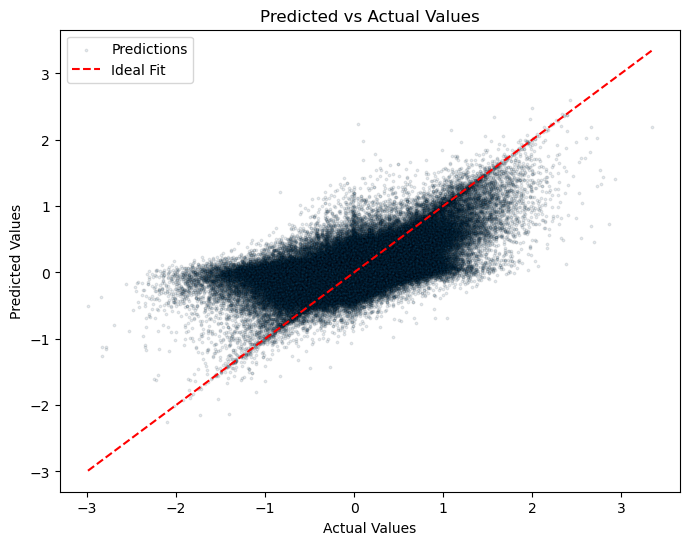

In [28]:
# Now predict on the training data (or on a held-out test set if available)
y_pred = loaded_bst.predict(dall)

# Plot predicted vs. actual values:
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.1, edgecolors='black', s=3, label="Predictions")
# Plot an ideal 45-degree line (y=x) for reference.
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()

Selected INCPER values and targets:
Sample 1 INCPER: -1.300366093386219  Actual target: 0.503042759
Sample 2 INCPER: -5.4850591253993016e-05  Actual target: 0.065885468
Sample 3 INCPER: 1.6500281870546134  Actual target: -0.882262696


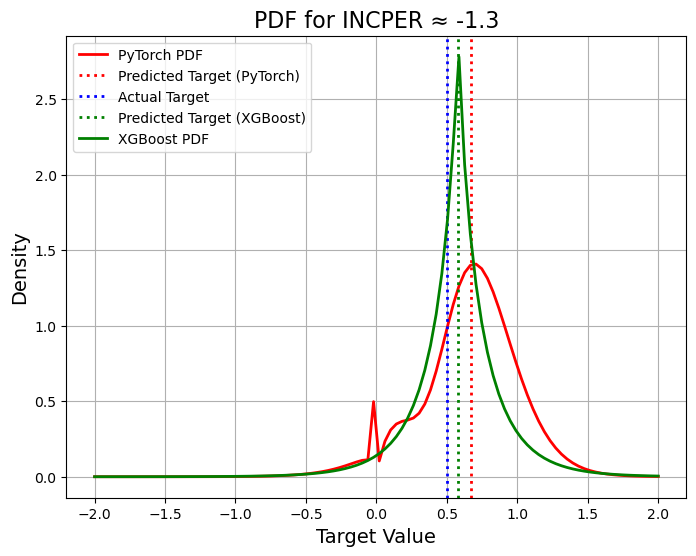

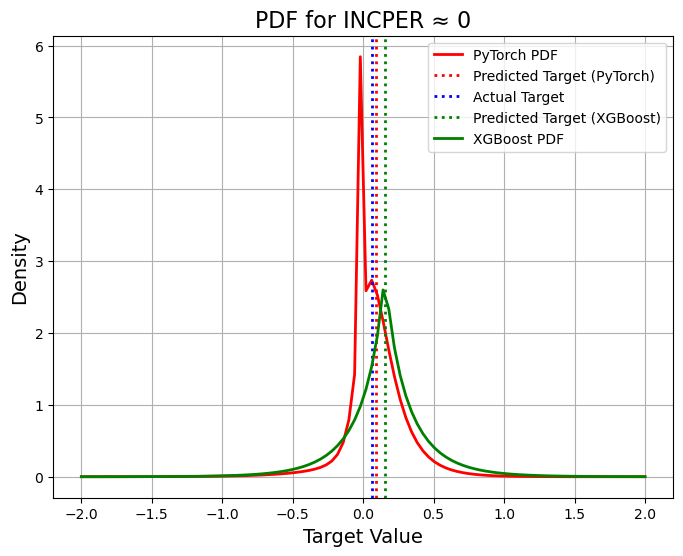

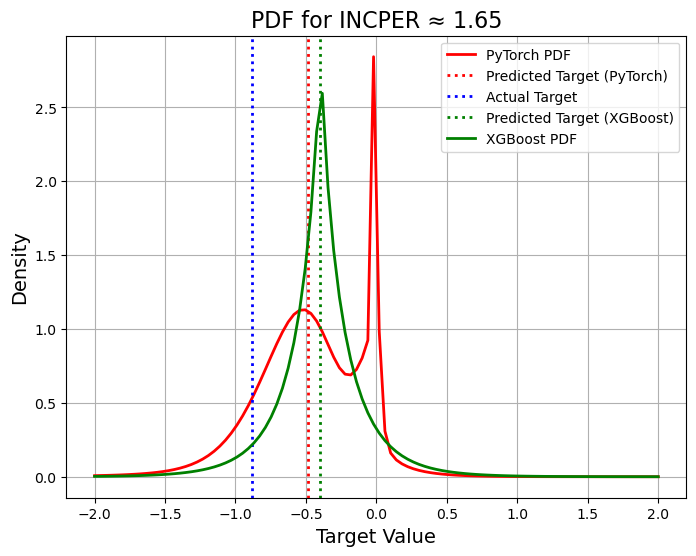

In [22]:
# ------------------------
# Helper functions to compute density values
# ------------------------
def gamma_pdf(y, alpha, scale, eps=1e-8):
    """
    Compute Gamma pdf for y > 0.
    pdf(y; alpha, scale) = [alpha^alpha/(Γ(alpha)*scale^alpha)] * y^(alpha-1) * exp(-alpha*y/scale)
    """
    return (alpha**alpha / (gamma_func(alpha) * scale**alpha)) * (y**(alpha - 1)) * np.exp(-alpha * y / scale + eps)

def mirrored_gamma_pdf(y, alpha, scale, eps=1e-8):
    """
    Compute mirrored Gamma pdf for y < 0.
    Define t = -y, then pdf(y; alpha, scale) = [alpha^alpha/(Γ(alpha)*scale^alpha)] * t^(alpha-1) * exp(alpha*y/scale)
    """
    return (alpha**alpha / (gamma_func(alpha) * scale**alpha)) * ((-y)**(alpha - 1)) * np.exp(alpha * y / scale + eps)

# ------------------------
# Extended plotting function that now:
#  - Plots the PyTorch predicted PDF in red.
#  - Adds a vertical red dotted line for the PyTorch predicted target.
#  - Adds the XGBoost predicted target (vertical green line) and its corresponding
#    generalized normal PDF (green curve) with beta=0.846 and alpha=0.156.
# ------------------------
def plot_pdf_for_instance_with_targets(model, x_sample, actual_target, device, title="", xgb_model=None):
    """
    For a given sample instance (x_sample) and its ground-truth target value,
    evaluate the predicted probability density function (PDF) over a grid and:
      - Plot the PyTorch predicted PDF (in red).
      - Draw a red dotted vertical line for the PyTorch predicted target.
      - Draw a blue dotted vertical line for the actual target.
      - If an XGBoost model is provided:
          • Compute its prediction.
          • Draw a green dotted vertical line at the XGBoost predicted target.
          • Overlay a green generalized normal PDF (β=0.846, α=0.156) centered at that prediction.
    
    Parameters:
      model         : Trained PyTorch model.
      x_sample      : Torch tensor input of shape [1, input_dim].
      actual_target : Float, the ground-truth target value.
      device        : Device string, e.g. "cuda" or "cpu".
      title         : Plot title.
      xgb_model     : (Optional) Loaded XGBoost model.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(x_sample.to(device))
        # Extract outputs and squeeze out batch dimensions.
        rho = outputs["rho"].squeeze().item()              # scalar gating probability
        pos_pi = outputs["pos_pi"].squeeze()                 # shape: (2,)
        pos_alpha = outputs["pos_alpha"].squeeze()           # shape: (2,)
        pos_scale = outputs["pos_scale"].squeeze()           # shape: (2,)
        neg_pi = outputs["neg_pi"].squeeze()                 # shape: (2,)
        neg_alpha = outputs["neg_alpha"].squeeze()           # shape: (2,)
        neg_scale = outputs["neg_scale"].squeeze()           # shape: (2,)

    # --- Compute the PyTorch predicted target ---
    # For the positive branch: weighted average of scale outputs.
    pos_pred = pos_pi[0].item() * pos_scale[0].item() + pos_pi[1].item() * pos_scale[1].item()
    # For the negative branch: negative weighted average.
    neg_pred = - (neg_pi[0].item() * neg_scale[0].item() + neg_pi[1].item() * neg_scale[1].item())
    predicted_target = rho * pos_pred + (1 - rho) * neg_pred

    # --- Evaluate the PyTorch predicted PDF over a grid ---
    y_vals = np.linspace(-2, 2, 100)
    pdf_vals = np.zeros_like(y_vals)

    # Positive branch for y >= 0.
    mask_pos = y_vals >= 0
    if np.any(mask_pos):
        y_pos = y_vals[mask_pos]
        pos_pdf = ( pos_pi[0].item() * gamma_pdf(y_pos, pos_alpha[0].item(), pos_scale[0].item()) +
                    (1 - pos_pi[0].item()) * gamma_pdf(y_pos, pos_alpha[1].item(), pos_scale[1].item()) )
        pdf_vals[mask_pos] = rho * pos_pdf

    # Negative branch for y < 0.
    mask_neg = y_vals < 0
    if np.any(mask_neg):
        y_neg = y_vals[mask_neg]
        neg_pdf = ( neg_pi[0].item() * mirrored_gamma_pdf(y_neg, neg_alpha[0].item(), neg_scale[0].item()) +
                    (1 - neg_pi[0].item()) * mirrored_gamma_pdf(y_neg, neg_alpha[1].item(), neg_scale[1].item()) )
        pdf_vals[mask_neg] = (1 - rho) * neg_pdf

    # Patch the density at 0.
    epsilon = 1e-3
    pos_pdf_zero = ( pos_pi[0].item() * gamma_pdf(np.array([epsilon]), pos_alpha[0].item(), pos_scale[0].item()) +
                     (1 - pos_pi[0].item()) * gamma_pdf(np.array([epsilon]), pos_alpha[1].item(), pos_scale[1].item()) )
    neg_pdf_zero = ( neg_pi[0].item() * mirrored_gamma_pdf(np.array([-epsilon]), neg_alpha[0].item(), neg_scale[0].item()) +
                     (1 - neg_pi[0].item()) * mirrored_gamma_pdf(np.array([-epsilon]), neg_alpha[1].item(), neg_scale[1].item()) )
    pdf_at_zero = rho * pos_pdf_zero[0] + (1 - rho) * neg_pdf_zero[0]
    idx_zero = np.argmin(np.abs(y_vals))
    pdf_vals[idx_zero] = pdf_at_zero

    # --- Create the plot ---
    plt.figure(figsize=(8, 6))
    # Plot the PyTorch predicted PDF in red.
    plt.plot(y_vals, pdf_vals, label="PyTorch PDF", color="r", linewidth=2)
    # Vertical lines for PyTorch predictions and actual target.
    plt.axvline(x=predicted_target, color="r", linestyle=":", linewidth=2, label="Predicted Target (PyTorch)")
    plt.axvline(x=actual_target, color="b", linestyle=":", linewidth=2, label="Actual Target")

    # --- If an XGBoost model is provided, compute its prediction and generalized normal PDF ---
    if xgb_model is not None:
        # Convert the torch tensor to a NumPy array.
        x_sample_np = x_sample.cpu().numpy()
        # Create a DMatrix while supplying the expected feature names.
        dmatrix = xgb.DMatrix(x_sample_np, feature_names=input_features)
        xgb_pred_arr = xgb_model.predict(dmatrix)
        xgb_pred = xgb_pred_arr[0]

        # Add a vertical green dotted line for the XGBoost predicted target.
        plt.axvline(x=xgb_pred, color="g", linestyle=":", linewidth=2, label="Predicted Target (XGBoost)")

        # Compute the generalized normal PDF (with β=0.846 and α=0.156) centered at xgb_pred.
        beta_param = 0.846
        alpha_param = 0.156
        # Compute the normalization constant.
        norm_const = beta_param / (2 * alpha_param * gamma_func(1 / beta_param))
        xgb_pdf_vals = norm_const * np.exp(- (np.abs(y_vals - xgb_pred) / alpha_param)**beta_param)
        # Overlay the XGBoost generalized normal PDF as a green curve.
        plt.plot(y_vals, xgb_pdf_vals, label="XGBoost PDF", color="g", linewidth=2)

    plt.xlabel("Target Value", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------
# Helper to select a sample based on INCPER
# ------------------------
def select_sample_by_incp(df, target_incp):
    """
    Given a DataFrame df and a desired INCPER value, return a single sample (as a DataFrame)
    that is closest to that target (includes the target column).
    """
    idx = (df["INCPER"] - target_incp).abs().idxmin()
    return df.loc[[idx]]

# ------------------------
# Example: Select three sample instances and compare predictions
# ------------------------
# Assume df_data is a DataFrame that contains all features (including INCPER) and a "target" column.
# Also, ensure that 'input_features' exactly matches the feature columns used in the XGBoost model.
input_features = list(df_data.drop(columns=["target"]).columns)

# Select samples based on desired INCPER values.
sample1_df = select_sample_by_incp(df_data, -1.3)
sample2_df = select_sample_by_incp(df_data, 0)
sample3_df = select_sample_by_incp(df_data, 1.65)

# Extract the corresponding actual target values.
actual_target1 = sample1_df["target"].values[0]
actual_target2 = sample2_df["target"].values[0]
actual_target3 = sample3_df["target"].values[0]

# Convert the feature data (dropping the "target" column) to torch tensors.
x_sample1 = torch.tensor(sample1_df.drop(columns=["target"]).values, dtype=torch.float32)
x_sample2 = torch.tensor(sample2_df.drop(columns=["target"]).values, dtype=torch.float32)
x_sample3 = torch.tensor(sample3_df.drop(columns=["target"]).values, dtype=torch.float32)

print("Selected INCPER values and targets:")
print("Sample 1 INCPER:", sample1_df["INCPER"].values[0], " Actual target:", actual_target1)
print("Sample 2 INCPER:", sample2_df["INCPER"].values[0], " Actual target:", actual_target2)
print("Sample 3 INCPER:", sample3_df["INCPER"].values[0], " Actual target:", actual_target3)

# ------------------------
# Plot the PDFs for each sample.
# Pass the loaded XGBoost model to overlay its prediction and generalized normal PDF.
# ------------------------
plot_pdf_for_instance_with_targets(model, x_sample1, actual_target1, device,
                                   title="PDF for INCPER ≈ -1.3", xgb_model=loaded_bst)
plot_pdf_for_instance_with_targets(model, x_sample2, actual_target2, device,
                                   title="PDF for INCPER ≈ 0", xgb_model=loaded_bst)
plot_pdf_for_instance_with_targets(model, x_sample3, actual_target3, device,
                                   title="PDF for INCPER ≈ 1.65", xgb_model=loaded_bst)

In [ ]:
X = df_data.drop(columns=["target"])
y = df_data["target"]

# Split into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)